In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
data_path = ''
output_data_path = '/data/extracted/'

In [6]:
all_data = pd.DataFrame()

for file in os.listdir(data_path):
    open_file = pd.ExcelFile(data_path+file)
    #sheets = [name for name in open_file.sheet_names if ' P' in name]
    sheets = [name for name in open_file.sheet_names]

    for sheet in sheets:

        data = pd.read_excel(data_path+file, sheet_name=sheet, skiprows=6)[:11][['Unnamed: 0']+list(range(2009, 2021))].rename(columns={'Unnamed: 0': 'Region'}).set_index(['Region'])

        # Remove total string
        data.index = data.index.str.replace('Total ', '')

        # Calculate Europe
        data.loc['Europe'] = data.loc[['West Europe', 'Central Europe']].sum()

        # Rename columns
        data.drop(['West Europe', 'EU 28', 'Central Europe'], inplace=True)
        data.rename(index={'East Europe & Central Asia': 'Former USSR', 'E. Europe & C. Asia': 'Former USSR', 'West Asia': 'Middle East', 'East Asia': 'North East Asia'}, inplace=True)
        data['PRODUCT'] = sheet.split(' P')[0]

        all_data = pd.concat((all_data, data.reset_index()))


KeyError: '[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020] not in index'

In [21]:
all_data = pd.DataFrame()

for file in os.listdir(data_path):
    open_file = pd.ExcelFile(data_path+file)
    
    data = pd.read_excel(data_path+file, sheet_name='product', skiprows=6)[['Country']+list(range(2011, 2023))].dropna(subset=['Country']).set_index('Country')
    data['PRODUCT'] = file.split('_')[1]
    all_data = pd.concat((all_data, data.reset_index()))
    
name_conversions = {
    'ammonia': 'AMMONIA',
    'an': 'AMMONIUM NITRATE',
    'as': 'AMMONIUM SULPHATE',
    'can': 'CALCIUM AMMONIUM NITRATE',
    'urea': 'UREA'
}

all_data['PRODUCT'] = all_data['PRODUCT'].map(name_conversions)

In [30]:
fao = pd.read_csv('/Users/lukecullen/PycharmProjects/petrochemical-data/data/extra_inputs/FAOSTAT_data_en_4-28-2023.csv')[['Year','Element', 'Value']]
fao_filt = fao[fao['Element']=='Agricultural Use in nutrients'].set_index('Year')
ifa = all_data.groupby('PRODUCT').sum().sum()

fao_forecast = (fao_filt.loc[2020:]['Value']*(ifa[2020]/(fao_filt['Value'][2020]/1E6)))/1E6
fao_backcast = (fao_filt.loc[:2011]['Value']*(ifa[2011]/(fao_filt['Value'][2011]/1E6)))/1E6
year_addition = ((fao_forecast[2050]-fao_forecast[2020])/30)/fao_forecast[2020]

In [35]:
data_backcast = all_data[['Country', 2011, 'PRODUCT']]
for y in range(1978, 2011):
    data_backcast[y] = data_backcast[2011]*(fao_backcast[y]/fao_backcast[2011])

data_forecast = all_data[['Country', 2022, 'PRODUCT']]
for i, y in enumerate(range(2023, 2051)):
    data_forecast[y] = data_forecast[2022]+(year_addition*(i+1)*data_forecast[2022])

/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_4547/3123866840.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_backcast[y] = data_backcast[2011]*(fao_backcast[y]/fao_backcast[2011])
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_4547/3123866840.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_backcast[y] = data_backcast[2011]*(fao_backcast[y]/fao_backcast[2011])
/var/folders/xm/c2mlyq6s23nb_g6_v4fylb7h0000gn/T/ipykernel_4547/3123866840.py:3: SettingWithCopyWarning: 


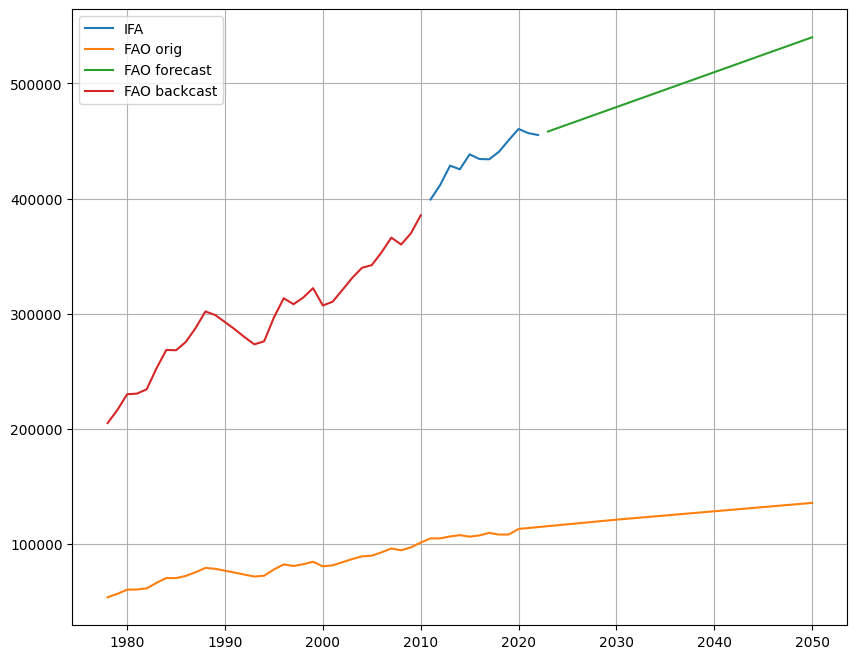

In [44]:
fig, ax = plt.subplots(1,1,figsize=[10,8], facecolor='white')
ax.plot(ifa.index[1:], ifa.values[1:], label='IFA')
ax.plot(fao_filt.index, (fao_filt['Value'])/1E6, label='FAO orig')
ax.plot(data_forecast.sum().index[3:], data_forecast.sum().values[3:], label='FAO forecast')
ax.plot(data_backcast.sum().index[3:],data_backcast.sum().values[3:], label='FAO backcast')
ax.legend()
ax.grid()

In [47]:
combined_data = data_backcast.drop(columns=[2011]).merge(all_data, on=['Country', 'PRODUCT']).merge(data_forecast.drop(columns=[2022]), on=['Country', 'PRODUCT'])

In [48]:
## Add uncertainties
production_uncertainty = 0.1

years = list(range(1978, 2051))

for col in years:
    if col<2009 or col>2020:
        combined_data[str(col)+'_sigma'] = combined_data[col]*production_uncertainty*2
    else: combined_data[str(col)+'_sigma'] = combined_data[col]*production_uncertainty

combined_data.to_csv(output_data_path+'IFA_country_production.csv', index=False)